In [1]:
import torch
import torchvision
from torch import nn
from torchvision import datasets, transforms
from torch.utils import data

In [2]:
# make a transform function to change the images to tensors and normailze them
transform = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), transforms.Lambda(lambda x: torch.flatten(x))])

In [3]:
# download train and test data
imageDataTrain = torchvision.datasets.MNIST(root = "./", train = True, download = True, transform = transform)
imageDataTest = torchvision.datasets.MNIST(root = "./", train = False, download = True, transform = transform)

In [4]:
# make dataloader objects
data_loader_train = torch.utils.data.DataLoader(dataset = imageDataTrain, batch_size = 16, shuffle = True)
data_loader_test = torch.utils.data.DataLoader(dataset = imageDataTest, batch_size = 16, shuffle = True)

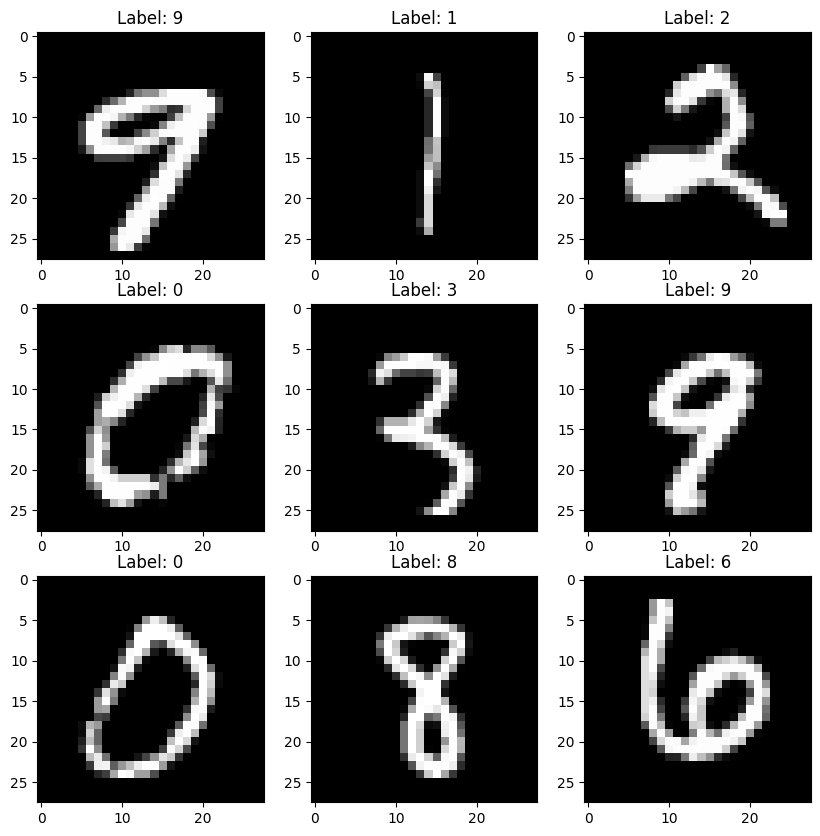

In [5]:
import matplotlib.pyplot as plt

# lets view the data in sets of 4 since our dataloader is loading batches of 4
dataiter = iter(data_loader_train)

images, labels = dataiter.next()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].view(28, 28).numpy(), cmap = 'gray')
    plt.title(f"Label: {labels[i]}")

In [6]:
# device agnostice code
device = "cuda" if torch.cuda.is_available() else "cpu"


In [7]:
# create model
class MultiClassMNIST(nn.Module):
    def __init__(self, hidden_features1, hiddenfeatures2, input_features = 784, output_features = 10):
        super().__init__()
        """
        initializes multiclass classification model for MNIST dataset.
        
        Args:
        
            input_features(int): Number of input features for the model
            hidden_features1(int): Number of hidden units between layers
            hidden_features2(int): Number of hidden units between layers
            output_features(int): Number of output features for the model
            
        Returns:
                Nothing
        """
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_features1),
            nn.ReLU(),
            nn.Linear(in_features = hidden_features1, out_features = hiddenfeatures2),
            nn.ReLU(),
            nn.Linear(in_features = hiddenfeatures2, out_features = output_features)
        )
            
    def forward(self, x):
            return self.linear_layer_stack(x)
            
            

model = MultiClassMNIST(300, 200).to(device)

In [8]:
# define loss function
loss_fn = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.1)

In [9]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

In [10]:
epochs = 10
torch.manual_seed(42)

for epoch in range(epochs):
    model.train()
    
    for X_train, y_train in data_loader_train:
        X_train, y_train = X_train.to(device), y_train.to(device)
        
        # forward
        y_logits = model(X_train)
        y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)
        
        # loss
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true = y_train,
                          y_pred = y_pred)
        
        # zero grad
        optimizer.zero_grad()
        
        # backprop
        loss.backward()
        
        # gradient descent
        optimizer.step()
        
    # lets test
    model.eval()
    with torch.inference_mode():
        
        for X_test, y_test in data_loader_test:
            X_test, y_test = X_test.to(device), y_test.to(device)
            
            # forward
            test_logits = model(X_test)
            test_pred = torch.softmax(test_logits, dim = 1).argmax(dim = 1)
            
            # loss
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true = y_test,
                                   y_pred = test_pred)
            
    # see whats happening
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.12619, Acc: 93.75% | Test Loss: 0.04219, Test Acc: 100.00%
Epoch: 1 | Loss: 0.35549, Acc: 87.50% | Test Loss: 0.04240, Test Acc: 100.00%
Epoch: 2 | Loss: 0.07715, Acc: 100.00% | Test Loss: 0.35192, Test Acc: 93.75%
Epoch: 3 | Loss: 0.01908, Acc: 100.00% | Test Loss: 0.00209, Test Acc: 100.00%
Epoch: 4 | Loss: 0.00142, Acc: 100.00% | Test Loss: 0.11970, Test Acc: 93.75%
Epoch: 5 | Loss: 0.09939, Acc: 93.75% | Test Loss: 0.00007, Test Acc: 100.00%
Epoch: 6 | Loss: 0.00392, Acc: 100.00% | Test Loss: 0.02720, Test Acc: 100.00%
Epoch: 7 | Loss: 0.02422, Acc: 100.00% | Test Loss: 0.00460, Test Acc: 100.00%
Epoch: 8 | Loss: 0.00571, Acc: 100.00% | Test Loss: 0.00868, Test Acc: 100.00%
Epoch: 9 | Loss: 0.01223, Acc: 100.00% | Test Loss: 0.27198, Test Acc: 93.75%


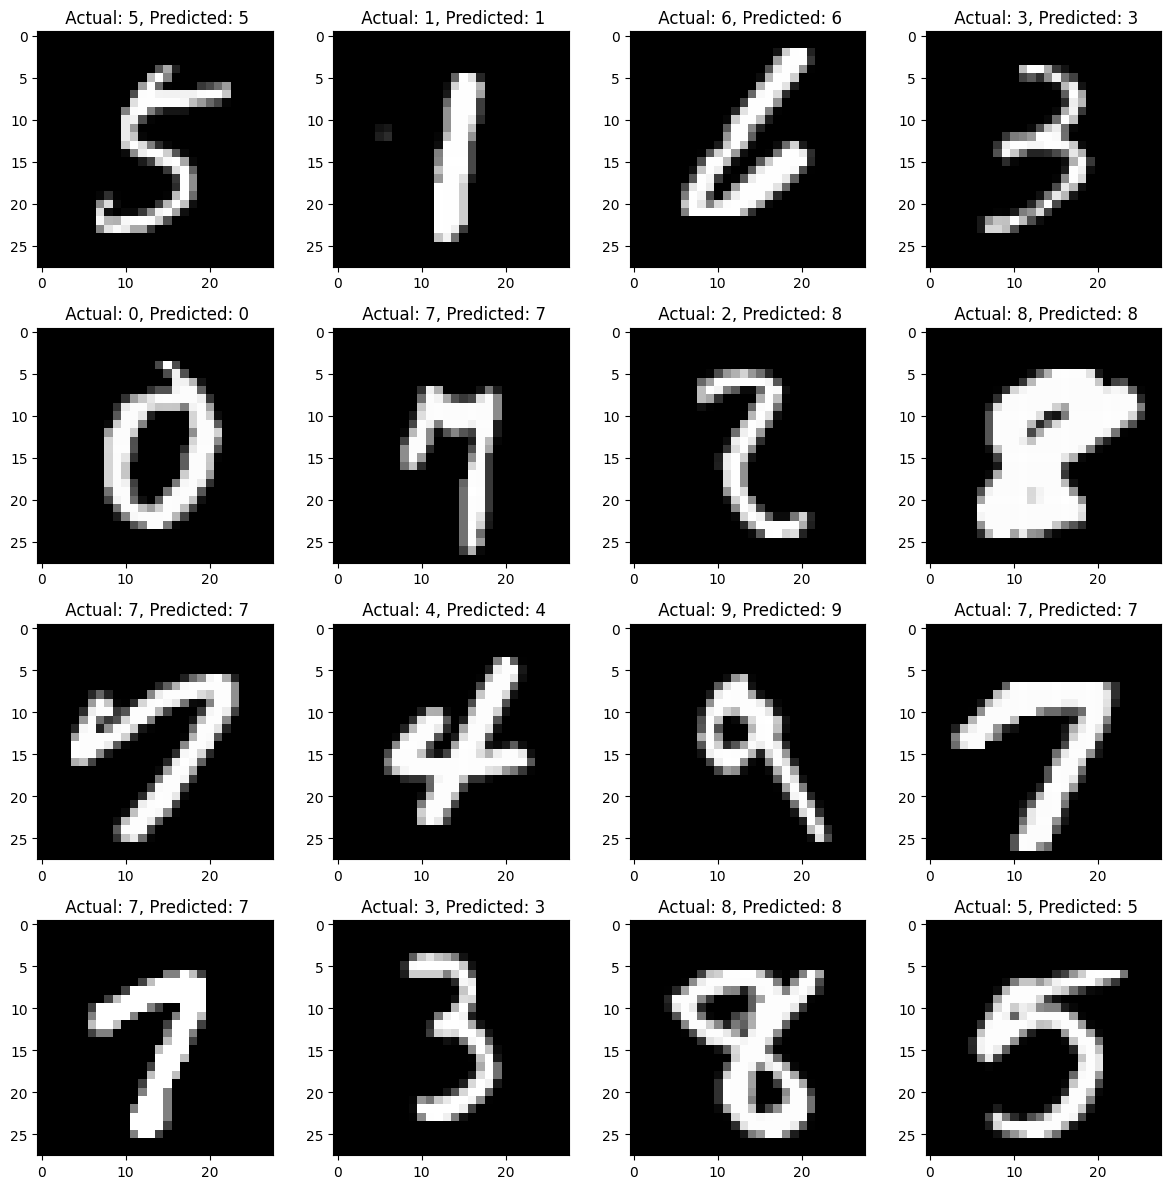

In [11]:
model.eval()

# Choose a batch from the test DataLoader
dataiter = iter(data_loader_test)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

with torch.inference_mode():
    # make predictions variable with X
    predicitons = torch.softmax(model(images), dim = 1).argmax(dim=1)
    
# put images and predictions on cpu for graphing
images = images.cpu()
predicitons = predicitons.cpu()

# plot the actual vs predicted
plt.figure(figsize = (12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].view(28, 28), cmap = 'gray')
    plt.title(f" Actual: {labels[i].item()}, Predicted: {predicitons[i].item()}")
plt.tight_layout()